In [1]:
# ================================
# 0. Imports & configuration
# ================================
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from PIL import Image

# Désactiver le GPU si besoin (problème RTX 50xx + TF2.18)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (8, 5)

print("TF :", tf.__version__)
print("Devices visibles :", tf.config.list_physical_devices())


2025-12-30 10:31:18.004008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-30 10:31:18.108511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767087078.148664    2840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767087078.160979    2840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-30 10:31:18.262949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TF : 2.18.0
Devices visibles : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-12-30 10:31:19.900876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
# ================================
# 1. Chargement des données
# ================================
DATA_PATH = "../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
df = pd.read_csv(DATA_PATH)

print("Shape brut :", df.shape)
df.head()


Shape brut : (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
# ================================
# 2. Préparation : catégories + chemins d'images
# ================================

def extract_main_category(tree_str):
    if pd.isna(tree_str):
        return np.nan
    s = str(tree_str).strip("[]'\" ")
    first_segment = s.split(">>")[0]
    return first_segment.strip()

df["category"] = df["product_category_tree"].apply(extract_main_category)

# Chemin d'image
IMAGE_DIR = "../data/Flipkart/Images"

def build_image_path(img_filename):
    if pd.isna(img_filename):
        return np.nan
    return os.path.join(IMAGE_DIR, img_filename)

df["image_path"] = df["image"].apply(build_image_path)

# On garde uniquement lignes avec cat + image
df_img = df.dropna(subset=["category", "image_path"]).reset_index(drop=True)
print("Shape après filtrage images :", df_img.shape)
df_img[["image", "image_path", "category"]].head()


Shape après filtrage images : (1050, 17)


,image,image_path,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,../data/Flipkart/Images/55b85ea15a1536d46b7190...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,../data/Flipkart/Images/7b72c92c2f6c40268628ec...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,../data/Flipkart/Images/64d5d4a258243731dc7bbb...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,../data/Flipkart/Images/d4684dcdc759dd9cdf4150...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,../data/Flipkart/Images/6325b6870c54cd47be6ebf...,Home Furnishing


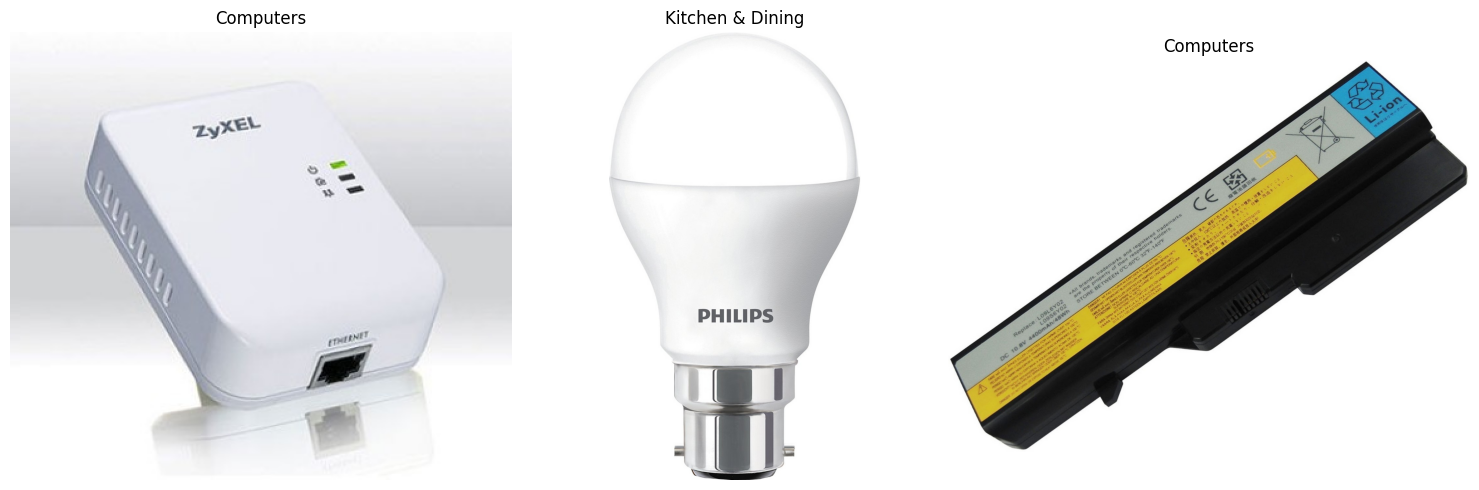

In [4]:
# ================================
# 3. Aperçu de quelques images
# ================================
N_EXEMPLES = 3
sample_df = df_img.sample(N_EXEMPLES, random_state=RANDOM_STATE)

fig, axes = plt.subplots(1, N_EXEMPLES, figsize=(15, 5))

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = row["image_path"]
    try:
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(row["category"])
        ax.axis("off")
    except Exception as e:
        ax.set_title("Erreur\n" + os.path.basename(img_path))
        ax.axis("off")
        print(f"Impossible de charger {img_path} :", e)

plt.tight_layout()
plt.show()


In [5]:
# ================================
# 4. Modèle CNN pré-entraîné (MobileNetV2)
# ================================
IMG_SIZE = (224, 224)

with tf.device("/CPU:0"):  # sécurité si souci GPU
    base_model = mobilenet_v2.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling="avg",   # vecteur de taille 1280
    )
    base_model.trainable = False

base_model.summary(line_length=120, show_trainable=False)


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Conv1 (Conv2D)                    │ (None, 112, 112, 32)         │               864 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bn_Conv1 (BatchNormalization)     │ (None, 112, 112, 32)         │               128 │ Conv1[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ Conv1_relu (ReLU)                 │ (None, 112, 112, 32)         │                 0 │ bn_Conv1[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise           │ (None, 112, 112, 32)         │               288 │ Conv1_relu[0][0]          
│ (DepthwiseConv2D)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise_BN        │ (None, 112, 112, 32)         │               128 │ expanded_conv_depthwise[0]
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_depthwise_relu      │ (None, 112, 112, 32)         │                 0 │ expanded_conv_depthwise_BN
│ (ReLU)                            │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_project (Conv2D)    │ (None, 112, 112, 16)         │               512 │ expanded_conv_depthwise_re
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ expanded_conv_project_BN          │ (None, 112, 112, 16)         │                64 │ expanded_conv_project[0][0
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand (Conv2D)           │ (None, 112, 112, 96)         │             1,536 │ expanded_conv_project_BN[0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand_BN                 │ (None, 112, 112, 96)         │               384 │ block_1_expand[0][0]      
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_expand_relu (ReLU)        │ (None, 112, 112, 96)         │                 0 │ block_1_expand_BN[0][0]   
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_pad (ZeroPadding2D)       │ (None, 113, 113, 96)         │                 0 │ block_1_expand_relu[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block_1_depthwise                 │ (None, 56, 56, 96)

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# ================================
# 5. Extraction des features images
# ================================

def load_and_preprocess_image(img_path, target_size=IMG_SIZE):
    """
    Charge une image, la redimensionne, la convertit en tenseur,
    applique le preprocess_input MobileNetV2.
    """
    try:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_v2.preprocess_input(x)
        return x
    except Exception as e:
        print(f"Erreur chargement image {img_path}: {e}")
        return None


def extract_image_features(img_paths, batch_size=32):
    features_list = []

    def process_batch(batch_paths):
        batch_tensors = []
        for p in batch_paths:
            x = load_and_preprocess_image(p, IMG_SIZE)
            if x is None:
                # Si image manquante, vecteur nul
                x = np.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
            batch_tensors.append(x)
        batch_tensors = np.vstack(batch_tensors)
        batch_features = base_model.predict(batch_tensors, verbose=0)
        return batch_features

    current_batch_paths = []
    for img_path in img_paths:
        current_batch_paths.append(img_path)
        if len(current_batch_paths) == batch_size:
            features_list.append(process_batch(current_batch_paths))
            current_batch_paths = []

    if current_batch_paths:
        features_list.append(process_batch(current_batch_paths))

    return np.vstack(features_list)


img_paths = df_img["image_path"].tolist()
y_img = df_img["category"].values

X_img_features = extract_image_features(img_paths, batch_size=32)

print("Shape features image (CNN) :", X_img_features.shape)


/home/aurelien/formation_openclassrooms/projet_6/.venv/lib/python3.10/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Shape features image (CNN) : (1050, 1280)


In [7]:
# ================================
# 6. Réduction de dimension (PCA + t-SNE)
# ================================
pca = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_img_features)
print("Shape après PCA :", X_pca.shape)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=RANDOM_STATE,
    init="pca",
)
X_tsne = tsne.fit_transform(X_pca)
print("Shape t-SNE :", X_tsne.shape)


Shape après PCA : (1050, 50)
Shape t-SNE : (1050, 2)


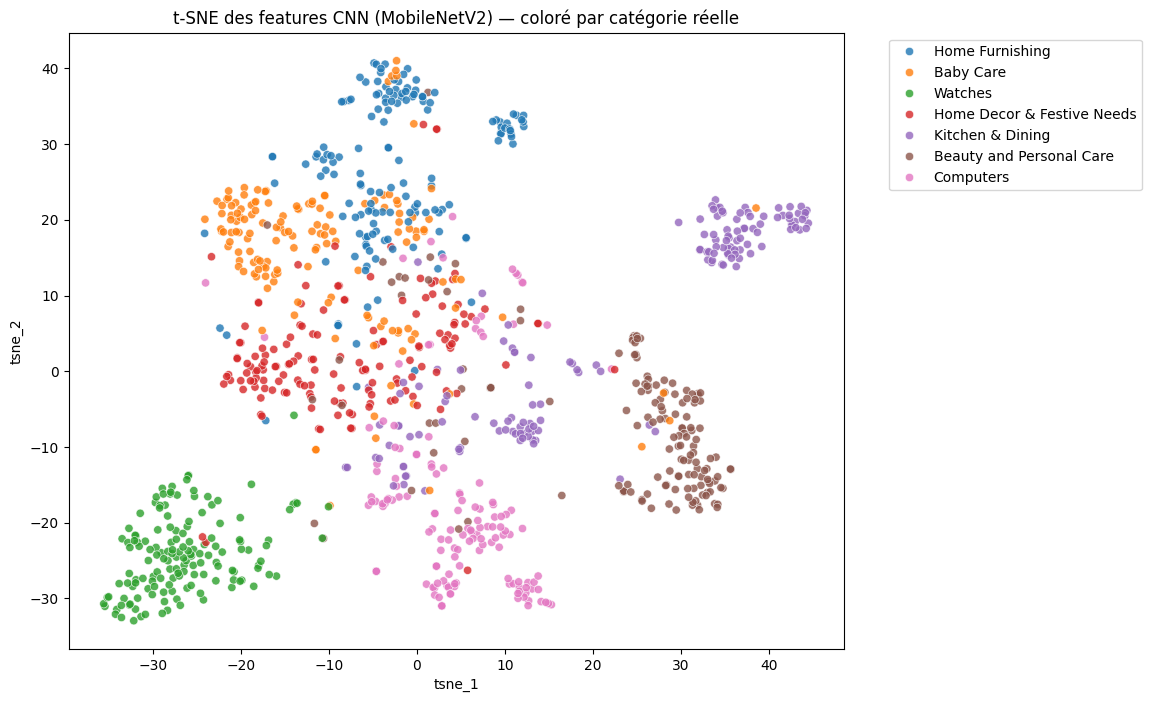

In [8]:
# ================================
# 7. t-SNE coloré par catégorie réelle
# ================================
tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "category": y_img,
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x="tsne_1",
    y="tsne_2",
    hue="category",
    palette="tab10",
    alpha=0.8,
)
plt.title("t-SNE des features CNN (MobileNetV2) — coloré par catégorie réelle")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [9]:
# ================================
# 8. KMeans sur t-SNE + ARI
# ================================
kmeans = KMeans(n_clusters=7, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_tsne)

ari_cnn = adjusted_rand_score(y_img, clusters)
print(f"Adjusted Rand Index (CNN images seules) : {ari_cnn:.3f}")


Adjusted Rand Index (CNN images seules) : 0.525


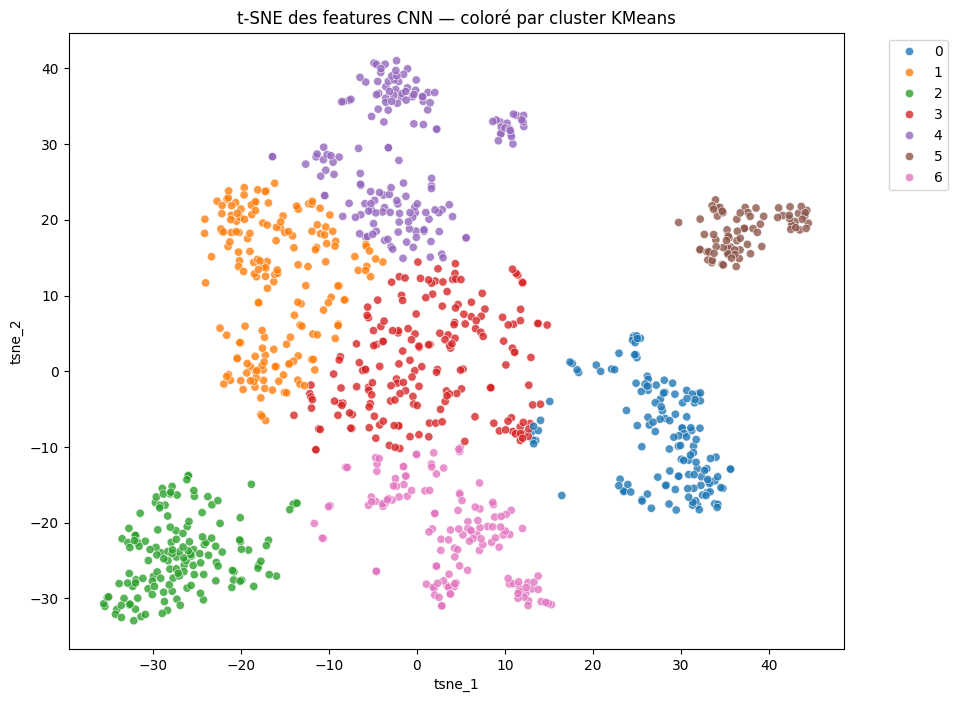

In [10]:
tsne_df["cluster"] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x="tsne_1",
    y="tsne_2",
    hue="cluster",
    palette="tab10",
    alpha=0.8,
)
plt.title("t-SNE des features CNN — coloré par cluster KMeans")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_img_features, y_img, stratify=y_img, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


                            precision    recall  f1-score   support

                 Baby Care       0.74      0.67      0.70        30
  Beauty and Personal Care       0.96      0.83      0.89        30
                 Computers       0.93      0.87      0.90        30
Home Decor & Festive Needs       0.87      0.90      0.89        30
           Home Furnishing       0.79      0.87      0.83        30
          Kitchen & Dining       0.82      0.93      0.88        30
                   Watches       0.97      1.00      0.98        30

                  accuracy                           0.87       210
                 macro avg       0.87      0.87      0.87       210
              weighted avg       0.87      0.87      0.87       210

